# TP : Réponse impulsionnelle de salle

/tableofcontents

In [25]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import wavio
import scipy.io as sio
import datetime
from scipy import signal
from scipy.fft import fft, fftfreq

## Simulation de l'effet de réverbération

1. Pour simuler le signal audio dans les différents environnements, on peut utiliser leur réponse impulsionnelle et la convoluer avec notre signal audio de chant enregistré dans une chambre anéchoïque. Ce type d'enregistrement permet de ne pas polluer notre signal d'entré avec la réponse impulsionnelle de la pièce d'enregistrement.

In [44]:
#vitesse du son
c=340; 

# signal émis
name_source = 'singing.wav'

# RI
RI_nashville = '1st_baptist_nashville_far_wide.wav'
RI_university ='auditorium-university-s1r2_0_1.wav'
RI_sportcentre ='sportscentre_omni.wav';

# Lecture des données
fs, source = sio.wavfile.read(name_source)
fs_h_nashville, h_nashville = sio.wavfile.read(RI_nashville)
fs_h_university, h_university = sio.wavfile.read(RI_university)
fs_h_sportcentre, h_sportcentre = sio.wavfile.read(RI_sportcentre)

# Conversion en float
source = np.float64(source)
ho_nashville = np.float64(h_nashville)[:,0] # on garde 1 canal si plusieurs canaux
ho_university = np.float64(h_university)[:,0] # on garde 1 canal si plusieurs canaux
ho_sportcentre = np.float64(h_sportcentre)

# Réecchantillonage de la RI 
# (les deux signaux n'ont pas la même fréquence d'échantillonnage)
h_nashville = signal.resample(ho_nashville, int(len(ho_nashville)*fs/fs_h_nashville))
h_university = signal.resample(ho_university, int(len(ho_university)*fs/fs_h_university))
h_sportcentre = signal.resample(ho_sportcentre, int(len(ho_sportcentre)*fs/fs_h_sportcentre))

singing_nashville = signal.convolve(source, h_nashville, mode='full')
singing_university = signal.convolve(source, h_university, mode='full')
singing_sportcentre = signal.convolve(source, h_sportcentre, mode='full')

C:\Users\nicol\AppData\Local\Temp\ipykernel_11348\3620376710.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, source = sio.wavfile.read(name_source)
C:\Users\nicol\AppData\Local\Temp\ipykernel_11348\3620376710.py:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_h_nashville, h_nashville = sio.wavfile.read(RI_nashville)
C:\Users\nicol\AppData\Local\Temp\ipykernel_11348\3620376710.py:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_h_university, h_university = sio.wavfile.read(RI_university)
C:\Users\nicol\AppData\Local\Temp\ipykernel_11348\3620376710.py:16: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_h_sportcentre, h_sportcentre = sio.wavfile.read(RI_sportcentre)


2. Une fois les signaux simuler dans les environnements on peut les écouter afin de comprendre comment l'environnement affecte le signal d'origine.

In [27]:
# Restitution audio
print('Playing Singing in Nashville environnement')
sd.play(singing_nashville/max(singing_nashville),fs,blocking=True)

Playing Singing in Nashville environnement


In [28]:
# Restitution audio
print('Playing Singing in University environnement')
sd.play(singing_university/max(singing_university),fs,blocking=True)

Playing Singing in University environnement


In [29]:
# Restitution audio
print('Playing Singing in Sportcentre environnement')
sd.play(singing_sportcentre/max(singing_sportcentre),fs,blocking=True)

Playing Singing in Sportcentre environnement


On remarque qu'en fonction des différents environnements l'effet de réverbération est très différent. Plus la pièce est un espace vide plus l'effet est notable. Par exemple, c'est dans le gymnase là qu'il est le plus fort et à l'inverse il est le moins prononcé dans l'auditorium d'univerité. On peut aussi remarquer qu'un effet de réverbération trop important limite la claireté et donc la compréhension du son par l'observeur.

3. Pour expliquer ces différences, on peut analyser les réponses en fréquences des différents environnements.

(0.0, 24000.0)

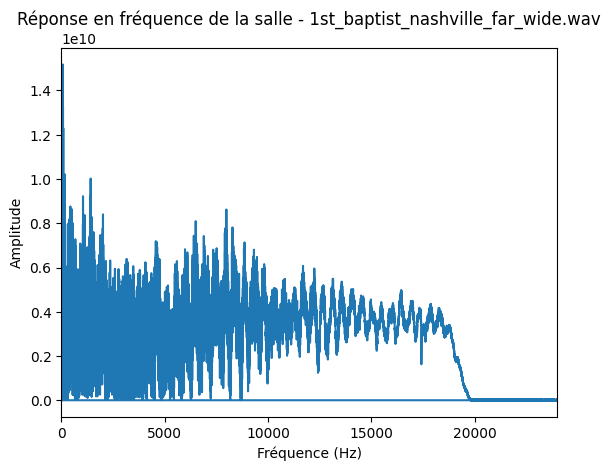

In [30]:
# FFT de la RI
fft_result = fft(h_nashville,len(h_nashville)*10)
fft_freqs = fftfreq(len(h_nashville)*10, 1/fs)  # Fréquences correspondantes
fft_amplitude = np.abs(fft_result)

plt.figure()
plt.plot(fft_freqs, fft_amplitude)
plt.title("Réponse en fréquence de la salle - " + RI_nashville)
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, fs/2) 

(0.0, 24000.0)

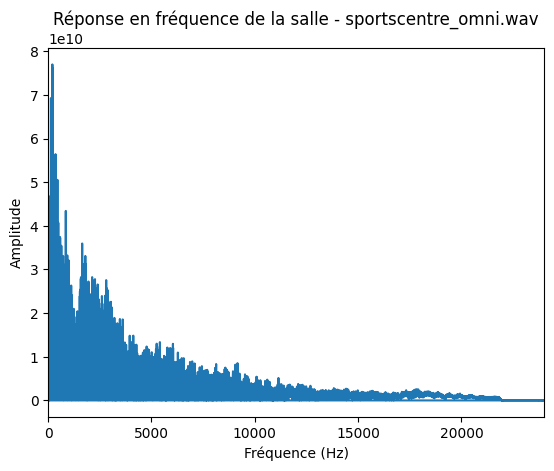

In [31]:
# FFT de la RI
fft_result = fft(h_sportcentre,len(h_sportcentre)*10)
fft_freqs = fftfreq(len(h_sportcentre)*10, 1/fs)  # Fréquences correspondantes
fft_amplitude = np.abs(fft_result)

plt.figure()
plt.plot(fft_freqs, fft_amplitude)
plt.title("Réponse en fréquence de la salle - " + RI_sportcentre)
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, fs/2)

On peut voir que les deux réponses sont très différentes. En effets la salle de sport amplifie les basses fréquences et ne semble pas avoir d'objectif particulier. A l'inverse, dans l'église, on voit une amplification moins forte mais plus constante dans la plage de sensibilité de l'oreil humaine. En vu du lieu, cette réponse semble être voulu pour avoir une propagration agraéble et audible d'un signal émis (un chant par exemple).

## Validation par simulation
### Simulation d'une mesure

1. D'abord, on commence par générer un signal de bruit blanc pour utiliser en signal émis.

In [107]:
# Paramètres
T = 10  # secondes
fs = 44000  # Hz
c = 340  # vitesse du son

# signal source
N = int(T * fs)
noise = np.random.randn(N)
noise = noise/max(abs(noise)) # normalisation

2. Pour simuler le signal reçu dans un environnement réverbérant on peut convoluer le signal dans un réponse de salle utilisée dans la partie précédente.

In [108]:
h_nashville = signal.resample(ho_nashville, int(len(ho_nashville)*fs/fs_h_nashville))
noise_nashville = signal.convolve(noise, h_nashville, mode='full')

In [45]:
# Restitution audio
print('Playing Noise in Nashville environnement')
sd.play(noise_nashville/max(noise_nashville),fs,blocking=True)

Playing Noise in Nashville environnement


### Estimation de la réponse impulsionnelle de la salle

1. Pour estimer la réponse impulsionnelle, on peut émettre un bruit blanc dans la salle que l'on veut caractériser et lire le signal reçu. En calculant l'intercorrelation entre les deux signaux émis et reçu on trouvera la réponse impulsionnelle de la salle.

In [147]:
estimation = signal.correlate(noise_nashville, noise, mode='full')

2. 

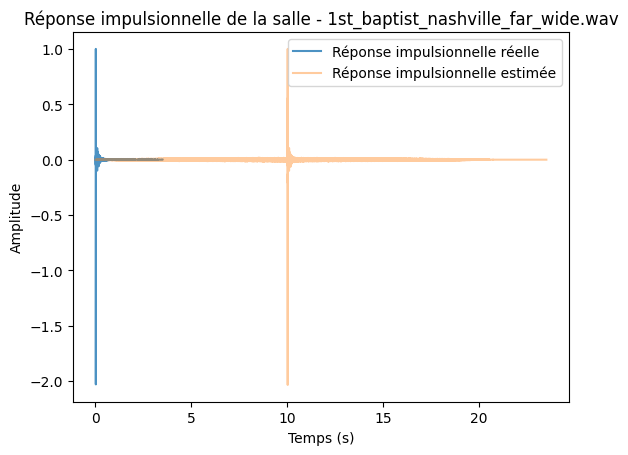

In [148]:
th = np.arange(0, len(estimation))/fs  # Fréquences correspondantes
th2 = np.arange(0, len(h_nashville))/fs  # Fréquences correspondantes

plt.figure()
plt.plot(th2, h_nashville/max(h_nashville), alpha=0.8, label="Réponse impulsionnelle réelle")
plt.plot(th, estimation/max(estimation), alpha=0.4, label="Réponse impulsionnelle estimée")
plt.title("Réponse impulsionnelle de la salle - " + RI_nashville)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()

On voit que la réponse estimée est similaire à la réponse réelle enregistrée. Il y a un effet d'échelle, (les deux signaux n'ont pas la même amplitude) et de translation (le signal n'est pas situé au même temps).

3. 

In [174]:
def add_measure_noise_RSB(signal: np.ndarray, RSB: int) -> np.ndarray:
    signal_power = np.var(noise_nashville)
    noise_power = signal_power / 10**(RSB/10)
    noise = np.random.normal(0, np.square(noise_power), len(signal))
    noise = noise/max(abs(noise)) # normalisation
    return signal + noise

In [175]:
RSBs = [1, 20, 100]

estimations = []
for RSB in RSBs:
    noise_nashville_measure_noise = add_measure_noise_RSB(noise_nashville, RSB)
    
    estimation = signal.correlate(noise_nashville_measure_noise, noise, mode='full')
    first_max_value = np.argmax(estimation)
    estimation = estimation[first_max_value:]
    estimation = estimation[:len(h_nashville)-1]
    estimations.append(estimation)

(-0.05, 0.5)

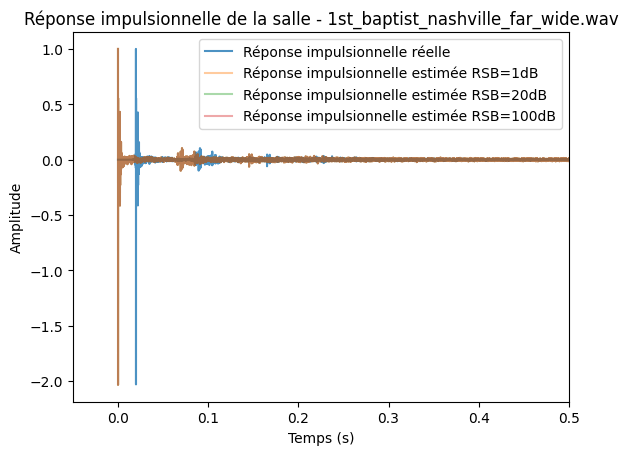

In [176]:
th = np.arange(0, len(estimations[0]))/fs  # Fréquences correspondantes
th2 = np.arange(0, len(h_nashville))/fs  # Fréquences correspondantes

plt.figure()
plt.plot(th2, h_nashville/max(h_nashville), alpha=0.8, label="Réponse impulsionnelle réelle")
for i, estimation in enumerate(estimations):
    plt.plot(th, estimation/max(estimation), alpha=0.4, label=f"Réponse impulsionnelle estimée RSB={RSBs[i]}dB")
plt.title("Réponse impulsionnelle de la salle - " + RI_nashville)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(-0.05, 0.5)

In [177]:
# Paramètres
Ts = [1, 5, 10]  # secondes
fs = 44000  # Hz
c = 340  # vitesse du son

noises = []
for T in Ts:
    N = int(T * fs)
    noise = np.random.randn(N)
    noise = noise/max(abs(noise)) # normalisation
    noises.append(noise)

In [179]:
estimations = []
for noise in noises:
    noise_nashville = signal.convolve(noise, h_nashville, mode='full')
    noise_nashville_measure_noise = add_measure_noise_RSB(noise_nashville, RSB)
    
    estimation = signal.correlate(noise_nashville_measure_noise, noise, mode='full')
    first_max_value = np.argmax(estimation)
    estimation = estimation[first_max_value:]
    estimation = estimation[:len(h_nashville)-1]
    estimations.append(estimation)

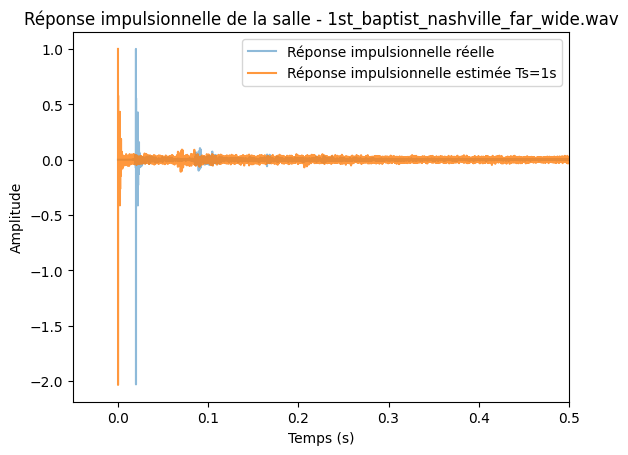

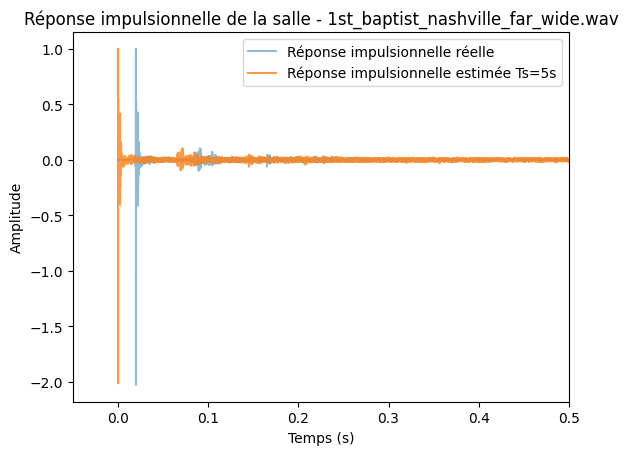

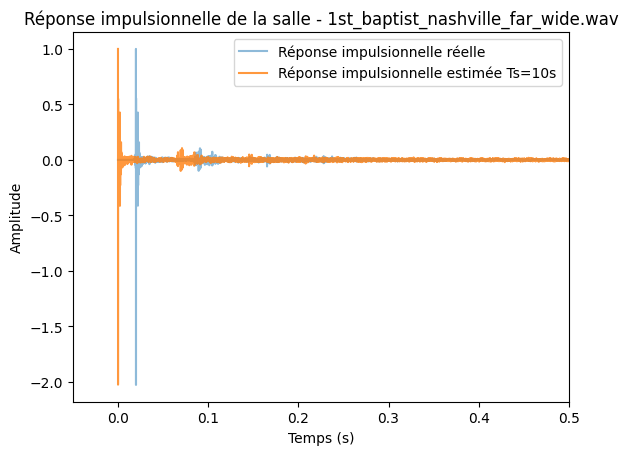

In [184]:
th = np.arange(0, len(estimations[0]))/fs  # Fréquences correspondantes
th2 = np.arange(0, len(h_nashville))/fs  # Fréquences correspondantes

for i, estimation in enumerate(estimations):
    plt.figure()
    plt.plot(th2, h_nashville/max(h_nashville), alpha=0.5, label="Réponse impulsionnelle réelle")
    plt.plot(th, estimation/max(estimation), alpha=0.8, label=f"Réponse impulsionnelle estimée Ts={Ts[i]}s")
    plt.title("Réponse impulsionnelle de la salle - " + RI_nashville)
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.xlim(-0.05, 0.5)